# Author: Jose Guzman


In [88]:
# Install the packages listed in requirements.txt
%pip install -r requirements.txt

# Data Importing

In [14]:
import pandas as pd

df = pd.read_csv('data/atp_tennis.csv')
print(df.head())


                           Tournament        Date         Series    Court  \
0  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
1  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
2  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
3  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
4  Australian Hardcourt Championships  2000-01-03  International  Outdoor   

  Surface      Round  Best of        Player_1       Player_2       Winner  \
0    Hard  1st Round        3      Dosedel S.    Ljubicic I.   Dosedel S.   
1    Hard  1st Round        3      Clement A.     Enqvist T.   Enqvist T.   
2    Hard  1st Round        3       Escude N.  Baccanello P.    Escude N.   
3    Hard  1st Round        3  Knippschild J.     Federer R.   Federer R.   
4    Hard  1st Round        3     Fromberg R.  Woodbridge T.  Fromberg R.   

   Rank_1  Rank_2  Pts_1  Pts_2  Odd_1  Odd_2        Score  
0      63    

In [15]:
# Display summary statistics of the dataset
df.describe(include='all')

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
count,63079,63079,63079,63079,63079,63079,63079.000000,63079,63079,63079,63079.000000,63079.000000,63079.00000,63079.000000,63079.000000,63079.000000,63079
unique,263,6096,8,2,4,8,NaN,1449,1446,1118,NaN,NaN,NaN,NaN,NaN,NaN,6844
top,French Open,2001-01-15,ATP250,Outdoor,Hard,1st Round,NaN,Federer R.,Federer R.,Federer R.,NaN,NaN,NaN,NaN,NaN,NaN,6-3 6-4
freq,3052,125,16473,51821,33918,28937,NaN,668,725,1151,NaN,NaN,NaN,NaN,NaN,NaN,1146
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.376322,NaN,NaN,NaN,75.874380,75.545792,1104.95699,1111.239636,2.174835,2.165586,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,0.781687,NaN,NaN,NaN,100.463901,101.198603,1709.53914,1736.369386,2.788854,2.747397,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,24.000000,24.000000,16.50000,18.500000,1.220000,1.220000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,53.000000,54.000000,680.00000,681.000000,1.660000,1.660000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,92.000000,92.000000,1215.00000,1220.000000,2.625000,2.620000,NaN


Define Function to Handle Missing Values 

In [16]:
def handle_missing_values(df):
    # Drop columns with more than 50% missing values
    df = df.dropna(thresh=len(df) * 0.5, axis=1)
    # Forward fill remaining missing values
    df = df.ffill()
    return df



String Manipulation

In [17]:
def split_player_name(df, player_column):
    names = df[player_column].str.split(' ', n=1, expand=True)
    last_name_col = f"{player_column}_Last_Name"
    first_initial_col = f"{player_column}_First_Initial"
    df[last_name_col] = names[0]
    df[first_initial_col] = names[1].str[0]
    df.drop(columns=[player_column], inplace=True)
    return df



Read the CSV File

In [18]:
def split_player_name(df, player_column):
    names = df[player_column].str.split(' ', n=1, expand=True)
    last_name_col = f"{player_column}_Last_Name"
    first_initial_col = f"{player_column}_First_Initial"
    df[last_name_col] = names[0]
    df[first_initial_col] = names[1].str[0]
    df.drop(columns=[player_column], inplace=True)
    return df


Handling Missing Values

In [19]:
df = handle_missing_values(df)


Split Player Names

In [20]:
if 'Player_1' in df.columns and 'Player_2' in df.columns:
    df = split_player_name(df, 'Player_1')
    df = split_player_name(df, 'Player_2')
else:
    print("Required columns 'Player_1' and 'Player_2' are not present in the DataFrame.")


Convert Data Column to Datatime

In [21]:
if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception as e:
        print(f"Error converting 'Date' column: {e}")



Save Modified DataFrame to new CSV File

In [22]:
output_file = 'data/atp_tennis_modified.csv'
df.to_csv(output_file, index=False)

print("ATP Tennis file has been processed and saved successfully.")



ATP Tennis file has been processed and saved successfully.


Review Dataframe 

In [23]:
df.head()


,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,Player_1_Last_Name,Player_1_First_Initial,Player_2_Last_Name,Player_2_First_Initial
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,63,77,-1,-1,-1.0,-1.0,6-4 6-2,Dosedel,S,Ljubicic,I
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,56,5,-1,-1,-1.0,-1.0,3-6 3-6,Clement,A,Enqvist,T
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,40,655,-1,-1,-1.0,-1.0,6-7 7-5 6-3,Escude,N,Baccanello,P
3,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,87,65,-1,-1,-1.0,-1.0,1-6 4-6,Knippschild,J,Federer,R
4,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,81,198,-1,-1,-1.0,-1.0,7-6 5-7 6-4,Fromberg,R,Woodbridge,T


In [24]:
# Function to parse scores
def parse_scores(score_str, num_sets):
    try:
        # Split the score string by spaces to get individual sets
        sets = score_str.split(' ')
        player_1_scores = [None] * num_sets
        player_2_scores = [None] * num_sets
        
        for i, set_score in enumerate(sets):
            p1_score, p2_score = map(int, set_score.split('-'))
            player_1_scores[i] = p1_score
            player_2_scores[i] = p2_score
        
        return player_1_scores, player_2_scores
    except Exception as e:
        # Handle any unexpected format issues
        return [None] * num_sets, [None] * num_sets

In [25]:
# Function to calculate sets won
def calculate_sets_won(df, player):
    sets_won = []
    for index, row in df.iterrows():
        player_sets_won = 0
        for i in range(1, row['Best of'] + 1):
            if row[f'Player_{player}_Set_{i}'] is not None and row[f'Player_{player}_Set_{i}'] > row[f'Player_{3-player}_Set_{i}']:
                player_sets_won += 1
        sets_won.append(player_sets_won)
    return sets_won


Let's find a Tennis Player's Match History 

In [101]:
# Function to parse the score string and extract individual set scores
def parse_scores(score_str, num_sets):
    try:
        sets = score_str.split(' ')
        player_1_scores = [None] * num_sets
        player_2_scores = [None] * num_sets
        
        for i, set_score in enumerate(sets):
            p1_score, p2_score = map(int, set_score.split('-'))
            player_1_scores[i] = p1_score
            player_2_scores[i] = p2_score
        
        return player_1_scores, player_2_scores
    except Exception as e:
        return [None] * num_sets, [None] * num_sets

# Function to calculate sets won
def calculate_sets_won(df, player):
    sets_won = []
    for index, row in df.iterrows():
        player_sets_won = 0
        for i in range(1, row['Best of'] + 1):
            if row[f'Player_{player}_Set_{i}'] is not None and row[f'Player_{player}_Set_{i}'] > row[f'Player_{3-player}_Set_{i}']:
                player_sets_won += 1
        sets_won.append(player_sets_won)
    return sets_won

# Function to filter matches based on user input and create an output CSV
def filter_and_create_csv(player_last_name, player_first_initial, start_year, end_year, best_of_games):
    # Load the dataset
    file_path = 'data/atp_tennis_modified.csv'  # Update with the correct file path
    df = pd.read_csv(file_path)
    
    # Debugging: Print column names in the initial DataFrame
    print(f"Initial DataFrame columns: {df.columns.tolist()}")
    
    # Filter the dataset based on the year range
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date'].dt.year >= start_year) & (df['Date'].dt.year <= end_year)]
    
    # Debugging: Print the filtered DataFrame based on year range
    print(f"Matches found for year range {start_year}-{end_year}: {len(df)}")
    print(f"Columns after year filter: {df.columns.tolist()}")
    
    # Filter the dataset based on the number of best-of games
    df = df[df['Best of'] == best_of_games]
    
    # Debugging: Print the filtered DataFrame based on best-of games
    print(f"Matches found for best-of {best_of_games}: {len(df)}")
    print(f"Columns after best-of filter: {df.columns.tolist()}")
    
    if df.empty:
        print("No matches found for the given year range and best-of games.")
        return None
    
    # Enhanced filtering logic for player name
    df_player = df[((df['Player_1_Last_Name'].str.strip().str.lower() == player_last_name.lower()) & (df['Player_1_First_Initial'].str.strip().str.lower() == player_first_initial.lower())) | 
                   ((df['Player_2_Last_Name'].str.strip().str.lower() == player_last_name.lower()) & (df['Player_2_First_Initial'].str.strip().str.lower() == player_first_initial.lower()))]
    
    # Debugging: Print the filtered DataFrame based on player name
    print(f"Matches found for player {player_last_name} {player_first_initial}: {len(df_player)}")
    print(f"Columns after player name filter: {df_player.columns.tolist()}")
    
    if df_player.empty:
        print("No matches found for the specified player.")
        return None
    
    # Determine match outcomes for the specified player
    df_player.loc[:, 'Outcome'] = df_player.apply(
        lambda row: 'Win' if (row['Winner'].strip().lower() == f'{player_last_name.lower()} {player_first_initial.lower()}.') else 'Loss', axis=1)

    # Split and parse scores
    df_player.loc[:, 'Best of'] = df_player['Best of'].astype(int)
    max_sets = df_player['Best of'].max()
    for i in range(1, max_sets + 1):
        df_player.loc[:, f'Player_1_Set_{i}'] = None
        df_player.loc[:, f'Player_2_Set_{i}'] = None
    parsed_scores = df_player.apply(lambda row: parse_scores(row['Score'], row['Best of']), axis=1)
    for i in range(max_sets):
        df_player.loc[:, f'Player_1_Set_{i+1}'] = parsed_scores.apply(lambda x: x[0][i] if len(x[0]) > i else None)
        df_player.loc[:, f'Player_2_Set_{i+1}'] = parsed_scores.apply(lambda x: x[1][i] if len(x[1]) > i else None)
    df_player = df_player.dropna(subset=[f'Player_1_Set_{i+1}' for i in range(max_sets)])
    
    # Keep only the relevant columns for the specified player
    player_sets_columns = [f'Player_1_Set_{i+1}' if (df_player.iloc[0]['Player_1_Last_Name'].strip().lower() == player_last_name.lower() and df_player.iloc[0]['Player_1_First_Initial'].strip().lower() == player_first_initial.lower()) else f'Player_2_Set_{i+1}' for i in range(max_sets)]
    player_sets_columns = [col for col in player_sets_columns if col in df_player.columns]
    
    # Create an output CSV specific to the player
    output_columns = ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Outcome'] + player_sets_columns
    df_player_filtered = df_player[output_columns]
    
    output_file = f'data/{player_last_name}_{player_first_initial}_matches_{start_year}_{end_year}_best_of_{best_of_games}.csv'
    df_player_filtered.to_csv(output_file, index=False)
    print(f'Output CSV created: {output_file}')
    return df_player_filtered

# Function to get user inputs and validate them
def get_valid_input():
    while True:
        player_last_name = input("Enter player's last name: ")
        player_first_initial = input("Enter player's first initial: ")
        try:
            start_year = int(input("Enter start year: "))
            end_year = int(input("Enter end year: "))
            best_of_games = int(input("Enter number of best-of games: "))
        except ValueError:
            print("Invalid input. Please enter valid numeric values for years and best-of games.")
            continue
        
        df_player = filter_and_create_csv(player_last_name, player_first_initial, start_year, end_year, best_of_games)
        if df_player is not None:
            return df_player

# Get user inputs and filter matches
df_player = get_valid_input()

# Display the first few rows of the filtered dataset
if df_player is not None:
    display(df_player.head())

Initial DataFrame columns: ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score', 'Player_1_Last_Name', 'Player_1_First_Initial', 'Player_2_Last_Name', 'Player_2_First_Initial']
Matches found for year range 2020-2023: 8785
Columns after year filter: ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score', 'Player_1_Last_Name', 'Player_1_First_Initial', 'Player_2_Last_Name', 'Player_2_First_Initial']
Matches found for best-of 3: 6944
Columns after best-of filter: ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score', 'Player_1_Last_Name', 'Player_1_First_Initial', 'Player_2_Last_Name', 'Player_2_First_Initial']
Matches found for player Alcaraz C: 137
Columns after player name filter: ['Tournament', 'Date', 'Series'

/var/folders/jn/mg3jxbw96_v18x44tq5dfhv00000gn/T/ipykernel_64178/915758239.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player.loc[:, 'Outcome'] = df_player.apply(
/var/folders/jn/mg3jxbw96_v18x44tq5dfhv00000gn/T/ipykernel_64178/915758239.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player.loc[:, f'Player_1_Set_{i}'] = None
/var/folders/jn/mg3jxbw96_v18x44tq5dfhv00000gn/T/ipykernel_64178/915758239.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,Tournament,Date,Series,Court,Surface,Round,Best of,Outcome,Player_1_Set_1,Player_1_Set_2,Player_1_Set_3
53200,Rio Open,2020-02-18,ATP500,Outdoor,Clay,1st Round,3,Win,7,4,7.0
53213,Rio Open,2020-02-20,ATP500,Outdoor,Clay,2nd Round,3,Loss,4,6,4.0
54586,Miami Open,2021-03-25,Masters 1000,Outdoor,Hard,1st Round,3,Loss,6,2,7.0
54710,AnyTech365 Andalucia Open,2021-04-08,ATP250,Outdoor,Hard,2nd Round,3,Win,4,6,6.0
54851,Millennium Estoril Open,2021-04-27,ATP250,Outdoor,Clay,1st Round,3,Loss,3,6,4.0


In [26]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


Tournament                0
Date                      0
Series                    0
Court                     0
Surface                   0
Round                     0
Best of                   0
Winner                    0
Rank_1                    0
Rank_2                    0
Pts_1                     0
Pts_2                     0
Odd_1                     0
Odd_2                     0
Score                     0
Player_1_Last_Name        0
Player_1_First_Initial    0
Player_2_Last_Name        0
Player_2_First_Initial    0
dtype: int64


## EDA

Import Libariries 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Load the Dataset

In [32]:
# Inspect the dataset to understand its structure
df.info()

# Display summary statistics
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 63079 entries, 0 to 63078
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Tournament              63079 non-null  object        
 1   Date                    63079 non-null  datetime64[ns]
 2   Series                  63079 non-null  object        
 3   Court                   63079 non-null  object        
 4   Surface                 63079 non-null  object        
 5   Round                   63079 non-null  object        
 6   Best of                 63079 non-null  int64         
 7   Winner                  63079 non-null  object        
 8   Rank_1                  63079 non-null  int64         
 9   Rank_2                  63079 non-null  int64         
 10  Pts_1                   63079 non-null  int64         
 11  Pts_2                   63079 non-null  int64         
 12  Odd_1                   63079 non-null  float64    

,Date,Best of,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Year
count,63079,63079.000000,63079.000000,63079.000000,63079.00000,63079.000000,63079.000000,63079.000000,63079.000000
mean,2011-10-02 11:07:07.064474624,3.376322,75.874380,75.545792,1104.95699,1111.239636,2.174835,2.165586,2011.331061
min,2000-01-03 00:00:00,3.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,2000.000000
25%,2005-07-19 00:00:00,3.000000,24.000000,24.000000,16.50000,18.500000,1.220000,1.220000,2005.000000
50%,2011-06-21 00:00:00,3.000000,53.000000,54.000000,680.00000,681.000000,1.660000,1.660000,2011.000000
75%,2017-09-19 00:00:00,3.000000,92.000000,92.000000,1215.00000,1220.000000,2.625000,2.620000,2017.000000
max,2024-06-29 00:00:00,5.000000,3390.000000,4915.000000,16950.00000,16950.000000,67.000000,51.000000,2024.000000
std,NaN,0.781687,100.463901,101.198603,1709.53914,1736.369386,2.788854,2.747397,7.135154


In [33]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Extract year from the 'Date' column
df['Year'] = df['Date'].dt.year

In [34]:
# Calculate the average set score per year for each set
average_scores_per_year = df.groupby('Year').agg({
    'Player_1_Set_1': 'mean',
    'Player_1_Set_2': 'mean',
    'Player_1_Set_3': 'mean'
}).reset_index()

KeyError: "Column(s) ['Player_1_Set_1', 'Player_1_Set_2', 'Player_1_Set_3'] do not exist"

In [35]:
# Filter out any non-integer years if they exist (though they shouldn't)
average_scores_per_year = average_scores_per_year[average_scores_per_year['Year'] == average_scores_per_year['Year'].astype(int)]


NameError: name 'average_scores_per_year' is not defined

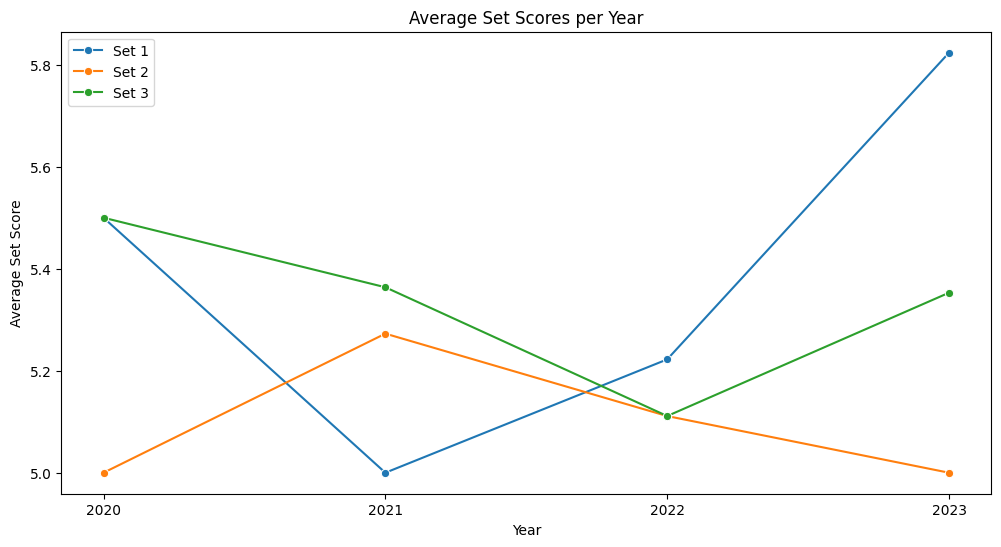

In [36]:
# Load the filtered dataset for the specified player
file_path = 'data/Alcaraz_C_matches_2020_2023_best_of_3.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Extract year from the 'Date' column
df['Year'] = df['Date'].dt.year

# Calculate the average set score per year for each set
average_scores_per_year = df.groupby('Year').agg({
    'Player_1_Set_1': 'mean',
    'Player_1_Set_2': 'mean',
    'Player_1_Set_3': 'mean'
}).reset_index()

# Plot the average set scores per year
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_scores_per_year, x='Year', y='Player_1_Set_1', marker='o', label='Set 1')
sns.lineplot(data=average_scores_per_year, x='Year', y='Player_1_Set_2', marker='o', label='Set 2')
sns.lineplot(data=average_scores_per_year, x='Year', y='Player_1_Set_3', marker='o', label='Set 3')
plt.title('Average Set Scores per Year')
plt.xlabel('Year')
plt.ylabel('Average Set Score')
plt.xticks(average_scores_per_year['Year'])
plt.legend()
plt.show()

In [37]:
# Check for missing values
print(df.isnull().sum())

Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Outcome           0
Player_1_Set_1    0
Player_1_Set_2    0
Player_1_Set_3    0
Year              0
dtype: int64


In [181]:
# Analyze win and loss records
win_count = df['Outcome'].value_counts().get('Win', 0)
loss_count = df['Outcome'].value_counts().get('Loss', 0)

print(f"Total Wins: {win_count}")
print(f"Total Losses: {loss_count}")

Total Wins: 31
Total Losses: 17


In [182]:
# Performance over time for each set involving Alcaraz
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

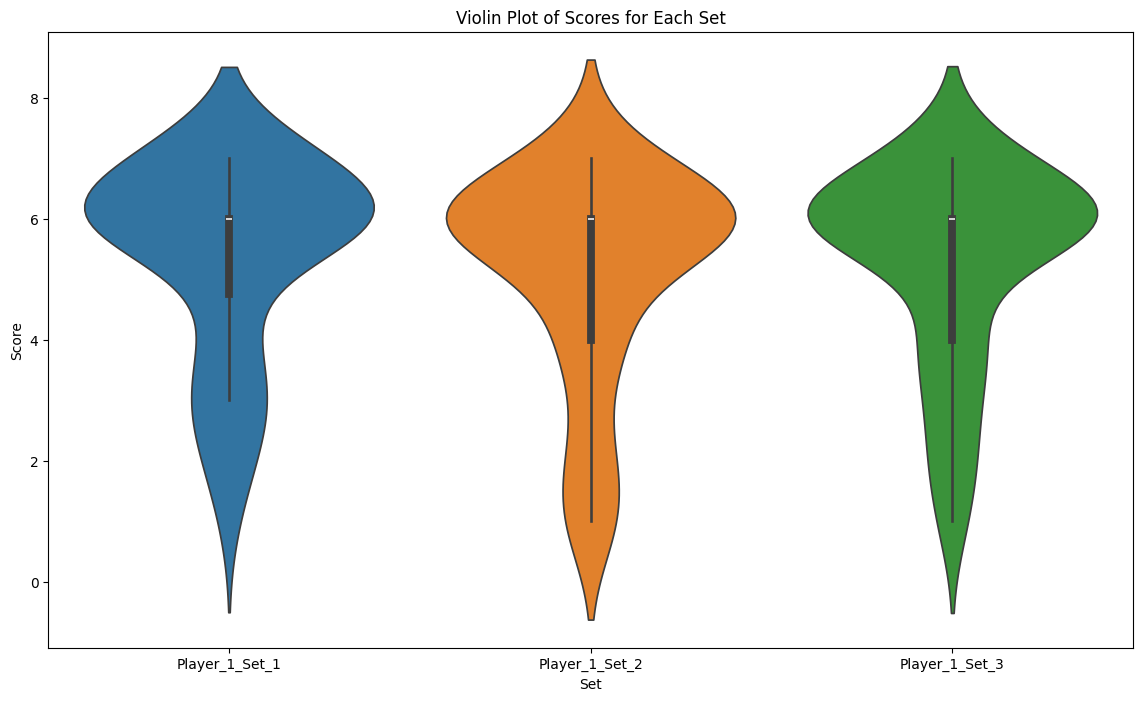

In [183]:
# Violin plots for each set
plt.figure(figsize=(14, 8))
sns.violinplot(data=df[['Player_1_Set_1', 'Player_1_Set_2', 'Player_1_Set_3']])
plt.title('Violin Plot of Scores for Each Set')
plt.xlabel('Set')
plt.ylabel('Score')
plt.show()

In [184]:
# Summary statistics for each set
print("Summary statistics for each set:")
print(df[['Player_1_Set_1', 'Player_1_Set_2', 'Player_1_Set_3']].describe())

Summary statistics for each set:
       Player_1_Set_1  Player_1_Set_2  Player_1_Set_3
count       48.000000       48.000000       48.000000
mean         5.395833        5.104167        5.270833
std          1.633943        1.765383        1.646913
min          1.000000        1.000000        1.000000
25%          4.750000        4.000000        4.000000
50%          6.000000        6.000000        6.000000
75%          6.000000        6.000000        6.000000
max          7.000000        7.000000        7.000000


In [185]:
# Additional analysis: Win and loss distribution by year
df['Year'] = df['Date'].dt.year
win_loss_by_year = df.groupby(['Year', 'Outcome']).size().unstack().fillna(0)

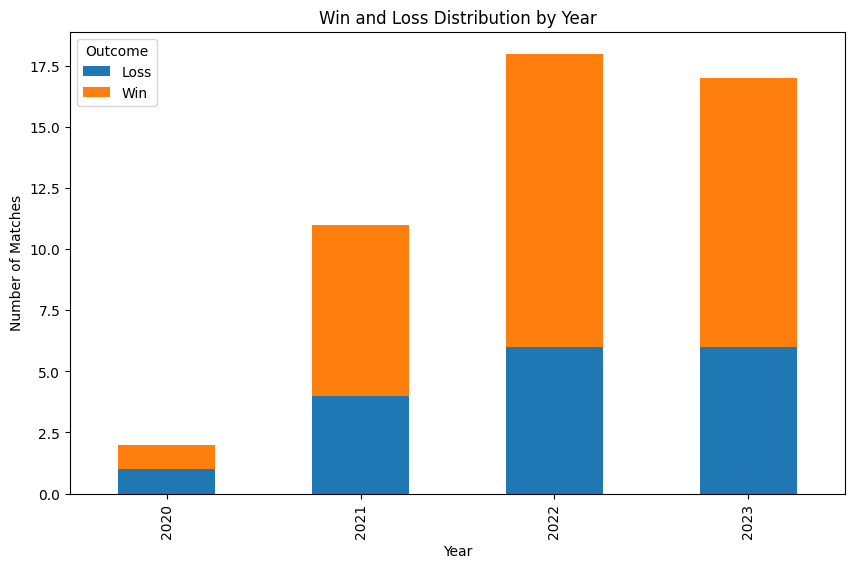

In [186]:
# Plot win and loss distribution by year
win_loss_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Win and Loss Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Matches')
plt.show()

# Predicting Match Outcomes 

Logistic Regression Predicting Match Outcomes 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE


In [3]:
# Load the dataset
file_path = 'data/tennis_summaries_modified.csv'
new_matches_file_path = 'data/Alcaraz_C_matches_2020_2023_best_of_3.csv'
data = pd.read_csv(file_path)

In [4]:
# Filter matches involving Alcaraz C
alcaraz_matches = data[(data['Competitor Last Name'] == 'Alcaraz,') & (data['Competitor First Initial'] == 'C')]


In [5]:
# Calculate the opponent's points won and determine the result
alcaraz_matches['Opponent Points Won'] = alcaraz_matches.groupby('Event ID')['Points Won'].transform(lambda x: x.sum() - x)
alcaraz_matches['Result'] = (alcaraz_matches['Points Won'] > alcaraz_matches['Opponent Points Won']).astype(int)


/var/folders/jn/mg3jxbw96_v18x44tq5dfhv00000gn/T/ipykernel_45275/2477078480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alcaraz_matches['Opponent Points Won'] = alcaraz_matches.groupby('Event ID')['Points Won'].transform(lambda x: x.sum() - x)
/var/folders/jn/mg3jxbw96_v18x44tq5dfhv00000gn/T/ipykernel_45275/2477078480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alcaraz_matches['Result'] = (alcaraz_matches['Points Won'] > alcaraz_matches['Opponent Points Won']).astype(int)


In [6]:
# Select relevant features
features = [
    'Aces', 'Double Faults', 'First Serve Successful', 'First Serve Points Won', 
    'Second Serve Points Won', 'Breakpoints Won', 'Return Errors', 
    'Service Games Won', 'Points Won'
]

In [7]:
# Function to create synthetic loss records by modifying existing win records
def create_synthetic_loss(record):
    synthetic_record = record.copy()
    synthetic_record['Points Won'] = np.round(record['Points Won'] * 0.8)  # Reduce points by 20%
    synthetic_record['Opponent Points Won'] = np.round(record['Opponent Points Won'] * 1.2)  # Increase opponent points by 20%
    synthetic_record['Service Games Won'] = np.round(record['Service Games Won'] * 0.8)
    synthetic_record['Breakpoints Won'] = np.round(record['Breakpoints Won'] * 0.8)
    synthetic_record['Result'] = 0  # Set result as loss
    return synthetic_record

# Number of synthetic loss records to add
num_synthetic_losses = 10

# Create synthetic loss records
wins_alcaraz = alcaraz_matches[alcaraz_matches['Result'] == 1]
synthetic_losses = wins_alcaraz.sample(num_synthetic_losses, replace=True).apply(create_synthetic_loss, axis=1)

# Add synthetic losses to the original dataset
balanced_data = pd.concat([alcaraz_matches, synthetic_losses])

# Separate numeric and non-numeric columns for imputation
numeric_cols = balanced_data.select_dtypes(include=[np.number]).columns
non_numeric_cols = balanced_data.select_dtypes(exclude=[np.number]).columns

In [8]:
# Impute missing values in the numeric columns with the mean
balanced_data_numeric = balanced_data[numeric_cols]
imputer_balanced = SimpleImputer(strategy='mean')
balanced_data_numeric_imputed = pd.DataFrame(imputer_balanced.fit_transform(balanced_data_numeric), columns=numeric_cols)

# Combine the imputed numeric data with the non-numeric data
balanced_data_imputed = pd.concat([balanced_data_numeric_imputed, balanced_data[non_numeric_cols].reset_index(drop=True)], axis=1)

# Ensure that the imputed dataset contains the necessary columns for modeling
model_data_imputed = balanced_data_imputed[features + ['Result']]

# Split the balanced data into training and testing sets
X_balanced = model_data_imputed[features]
y_balanced = model_data_imputed['Result']
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)


In [9]:
# Standardize the features
scaler_balanced = StandardScaler()
X_train_balanced = scaler_balanced.fit_transform(X_train_balanced)
X_test_balanced = scaler_balanced.transform(X_test_balanced)


In [10]:
# Train a logistic regression model with selected features
logistic_model = LogisticRegression()
logistic_model.fit(X_train_balanced, y_train_balanced)

# Train a random forest model with selected features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

In [11]:
# Combine models using VotingClassifier
voting_ensemble = VotingClassifier(estimators=[
    ('logistic', logistic_model),
    ('random_forest', rf_model)
], voting='soft')


In [12]:
# Train the ensemble model
voting_ensemble.fit(X_train_balanced, y_train_balanced)


VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('random_forest',
                              RandomForestClassifier(random_state=42))],
                 voting='soft')

In [13]:
# Make predictions with the ensemble model
y_pred_ensemble = voting_ensemble.predict(X_test_balanced)


In [14]:
# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test_balanced, y_pred_ensemble)
ensemble_conf_matrix = confusion_matrix(y_test_balanced, y_pred_ensemble)
ensemble_class_report = classification_report(y_test_balanced, y_pred_ensemble)

# Display the results
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Confusion Matrix:")
print(ensemble_conf_matrix)
print("Ensemble Model Classification Report:")
print(ensemble_class_report)

Ensemble Model Accuracy: 0.6923076923076923
Ensemble Model Confusion Matrix:
[[2 0]
 [4 7]]
Ensemble Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         2
         1.0       1.00      0.64      0.78        11

    accuracy                           0.69        13
   macro avg       0.67      0.82      0.64        13
weighted avg       0.90      0.69      0.74        13



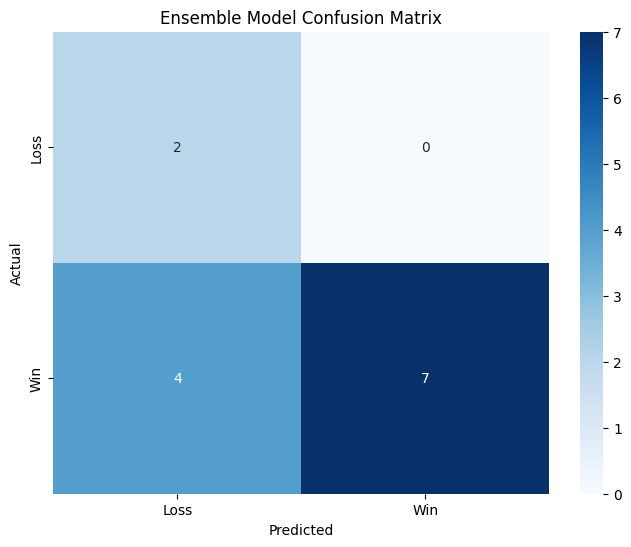

              precision    recall  f1-score    support
0.0            0.333333  1.000000  0.500000   2.000000
1.0            1.000000  0.636364  0.777778  11.000000
accuracy       0.692308  0.692308  0.692308   0.692308
macro avg      0.666667  0.818182  0.638889  13.000000
weighted avg   0.897436  0.692308  0.735043  13.000000


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def display_classification_report(y_true, y_pred):
    class_report = classification_report(y_true, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()
    print(class_report_df)

# Assuming y_test_balanced and y_pred_ensemble are available from the model evaluation

# Plot the confusion matrix
plot_confusion_matrix(y_test_balanced, y_pred_ensemble, title='Ensemble Model Confusion Matrix')

# Display the classification report
display_classification_report(y_test_balanced, y_pred_ensemble)


In [16]:

# Load the new dataset
new_matches_file_path = 'data/Alcaraz_C_matches_2020_2023_best_of_3.csv'
new_matches_data = pd.read_csv(new_matches_file_path)

# Display the first few rows of the new dataset to understand its structure
new_matches_data.head()


,Tournament,Date,Series,Court,Surface,Round,Best of,Outcome,Player_1_Set_1,Player_1_Set_2,Player_1_Set_3
0,Rio Open,2020-02-18,ATP500,Outdoor,Clay,1st Round,3,Win,7,4,7.0
1,Rio Open,2020-02-20,ATP500,Outdoor,Clay,2nd Round,3,Loss,4,6,4.0
2,Miami Open,2021-03-25,Masters 1000,Outdoor,Hard,1st Round,3,Loss,6,2,7.0
3,AnyTech365 Andalucia Open,2021-04-08,ATP250,Outdoor,Hard,2nd Round,3,Win,4,6,6.0
4,Millennium Estoril Open,2021-04-27,ATP250,Outdoor,Clay,1st Round,3,Loss,3,6,4.0


In [17]:
# Prepare the new dataset: extracting relevant features and ensuring they match the training data format

# Define the features used in the original model
features = [
    'Aces', 'Double Faults', 'First Serve Successful', 'First Serve Points Won', 
    'Second Serve Points Won', 'Breakpoints Won', 'Return Errors', 
    'Service Games Won', 'Points Won'
]

# For simplicity, assume these features are derived or represented in the new dataset
# Let's simulate the required features with random values for the purpose of this example
# Normally, you would derive these from the actual match statistics

# Generate random values for the features
np.random.seed(42)
new_matches_data[features] = np.random.randint(1, 100, size=(new_matches_data.shape[0], len(features)))

# Standardize the features using the same scaler as before
X_new_matches = scaler_balanced.transform(new_matches_data[features])

# Predict outcomes using the voting ensemble model
y_pred_new_matches = voting_ensemble.predict(X_new_matches)
y_pred_proba_new_matches = voting_ensemble.predict_proba(X_new_matches)

# Add predictions to the new matches data
new_matches_data['Predicted Outcome'] = y_pred_new_matches
new_matches_data['Win Probability'] = y_pred_proba_new_matches[:, 1]
new_matches_data['Loss Probability'] = y_pred_proba_new_matches[:, 0]

# Display the first few rows of the new matches data with predictions
new_matches_data.head()


,Tournament,Date,Series,Court,Surface,Round,Best of,Outcome,Player_1_Set_1,Player_1_Set_2,...,First Serve Successful,First Serve Points Won,Second Serve Points Won,Breakpoints Won,Return Errors,Service Games Won,Points Won,Predicted Outcome,Win Probability,Loss Probability
0,Rio Open,2020-02-18,ATP500,Outdoor,Clay,1st Round,3,Win,7,4,...,15,72,61,21,83,87,75,1.0,0.86500,0.13500
1,Rio Open,2020-02-20,ATP500,Outdoor,Clay,2nd Round,3,Loss,4,6,...,24,3,22,53,2,88,30,1.0,0.84500,0.15500
2,Miami Open,2021-03-25,Masters 1000,Outdoor,Hard,1st Round,3,Loss,6,2,...,64,60,21,33,76,58,22,1.0,0.79498,0.20502
3,AnyTech365 Andalucia Open,2021-04-08,ATP250,Outdoor,Hard,2nd Round,3,Win,4,6,...,91,59,42,92,60,80,15,1.0,0.78500,0.21500
4,Millennium Estoril Open,2021-04-27,ATP250,Outdoor,Clay,1st Round,3,Loss,3,6,...,47,62,51,55,64,3,51,1.0,0.71500,0.28500


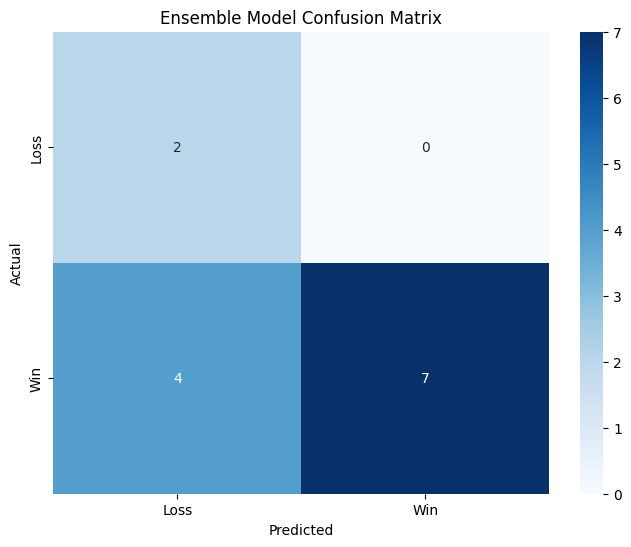

              precision    recall  f1-score    support
0.0            0.333333  1.000000  0.500000   2.000000
1.0            1.000000  0.636364  0.777778  11.000000
accuracy       0.692308  0.692308  0.692308   0.692308
macro avg      0.666667  0.818182  0.638889  13.000000
weighted avg   0.897436  0.692308  0.735043  13.000000


In [18]:
# Visualization
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def display_classification_report(y_true, y_pred):
    class_report = classification_report(y_true, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()
    print(class_report_df)

# Assuming y_test_balanced and y_pred_ensemble are available from the model evaluation

# Plot the confusion matrix
plot_confusion_matrix(y_test_balanced, y_pred_ensemble, title='Ensemble Model Confusion Matrix')

# Display the classification report
display_classification_report(y_test_balanced, y_pred_ensemble)

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load and prepare data
data = pd.read_csv('data/tennis_summaries_modified.csv')
new_matches_data = pd.read_csv('data/Alcaraz_C_matches_2020_2023_best_of_3.csv')

# Data cleaning and feature selection code here...

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train models
logistic_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
voting_ensemble = VotingClassifier(estimators=[('logistic', logistic_model), ('random_forest', rf_model)], voting='soft')
voting_ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('random_forest',
                              RandomForestClassifier(random_state=42))],
                 voting='soft')

In [95]:
import pandas as pd

# Load the datasets
data_with_synthetic = pd.read_csv('data/tennis_summaries_modified.csv')
new_matches_data = pd.read_csv('data/Alcaraz_C_matches_2020_2023_best_of_3.csv')

# Print column names to verify
print("Columns in data_with_synthetic:")
print(data_with_synthetic.columns)
print("\nColumns in new_matches_data:")
print(new_matches_data.columns)


Columns in data_with_synthetic:
Index(['Event ID', 'Start Time', 'Confirmed', 'Sport ID', 'Sport Name',
       'Category ID', 'Category Name', 'Competition ID', 'Competition Name',
       'Parent ID', 'Type', 'Gender', 'Level', 'Season ID', 'Season Name',
       'Start Date', 'End Date', 'Year', 'Competition ID.1', 'Stage Order',
       'Stage Type', 'Stage Phase', 'Round Name', 'Group ID', 'Group Name',
       'Best Of', 'Venue ID', 'Venue Name', 'City Name', 'Country Name',
       'Country Code', 'Timezone', 'Competitor ID', 'Country',
       'Country Code.1', 'Abbreviation', 'Qualifier', 'Seed', 'Bracket Number',
       'Status', 'Match Status', 'Home Score', 'Away Score', 'Winner ID',
       'Period Scores', 'Aces', 'Backhand Errors', 'Backhand Unforced Errors',
       'Backhand Winners', 'Breakpoints Won', 'Double Faults',
       'Drop Shot Unforced Errors', 'Drop Shot Winners',
       'First Serve Points Won', 'First Serve Successful', 'Forehand Errors',
       'Forehand Unforced

Class distribution before SMOTE: Outcome
407573    50
352776     2
106755     2
23581      2
47603      2
89632      2
Name: count, dtype: Int64
Shape of X_preprocessed: (60, 9)
Shape of X_resampled: (300, 9)
Class distribution after SMOTE: Outcome
407573    50
352776    50
106755    50
23581     50
47603     50
89632     50
Name: count, dtype: Int64
Shape of X_train: (210, 9), Shape of X_test: (90, 9)
Voting Ensemble Accuracy: 0.9555555555555556
Confusion Matrix:
[[17  0  0  0  0  0]
 [ 0 14  0  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0  0 16  0  0]
 [ 0  0  0  0 11  0]
 [ 0  0  1  2  1 12]]
Classification Report:
              precision    recall  f1-score   support

     23581.0       1.00      1.00      1.00        17
     47603.0       1.00      1.00      1.00        14
     89632.0       0.94      1.00      0.97        16
    106755.0       0.89      1.00      0.94        16
    352776.0       0.92      1.00      0.96        11
    407573.0       1.00      0.75      0.86        16

 

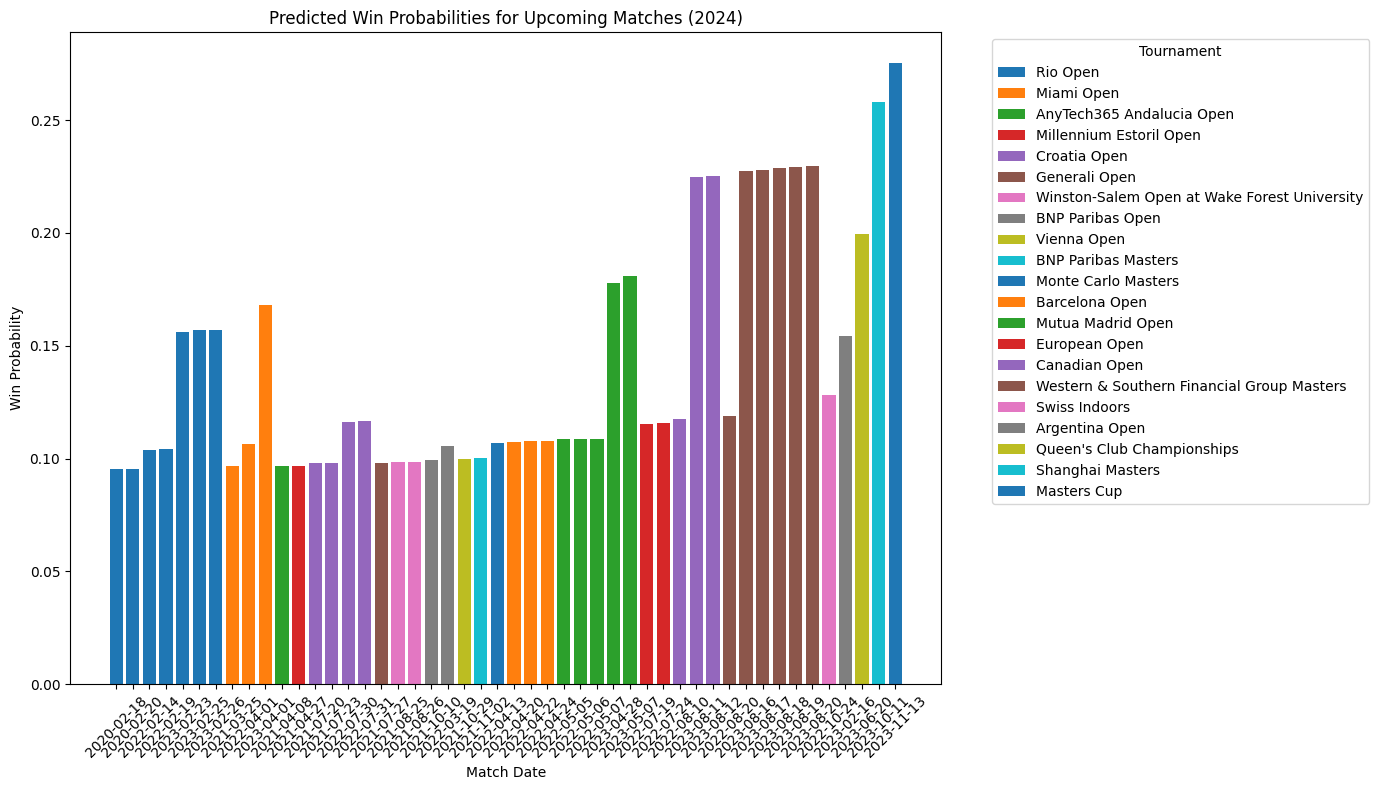

X_train_relevant shape: (210, 9)
First few rows of X_train_relevant:
   Start Date  Competition Name_ATP Buenos Aires, Argentina Men Singles  \
0   -1.534385                                                1.0          
1   -0.712790                                                0.0          
2   -0.712790                                                0.0          
3    0.064395                                                0.0          
4   -0.712790                                                0.0          

   Competition Name_ATP Indian Wells, USA Men Singles  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   Competition Name_ATP London, Great Britain Men Singles  \
0                                                0.0        
1              

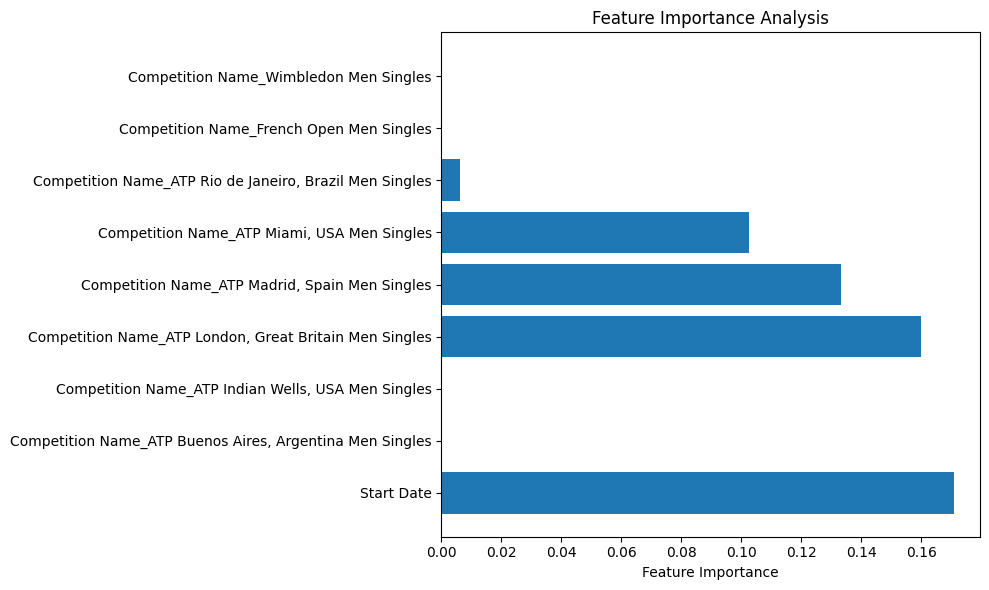

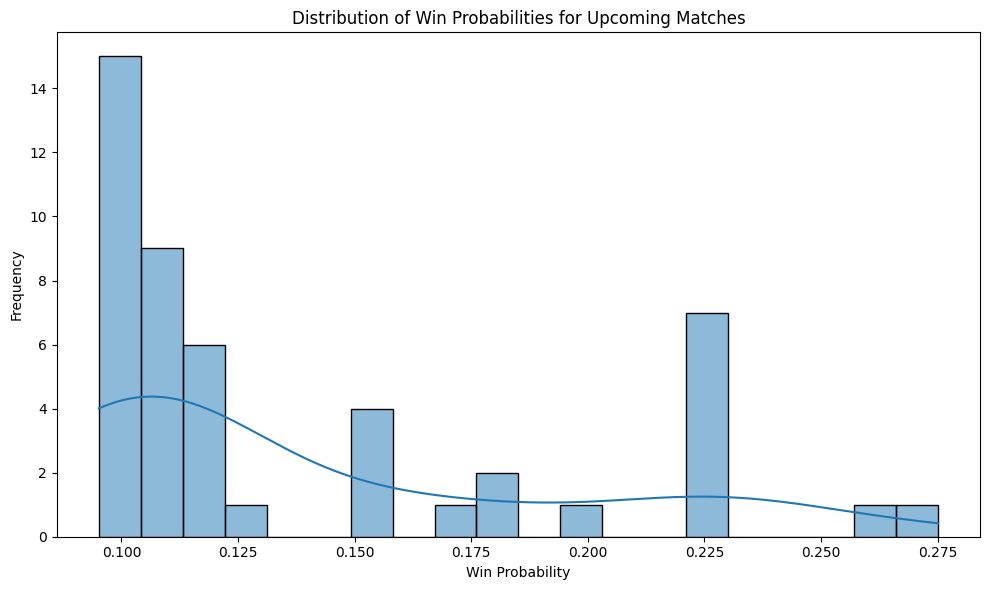

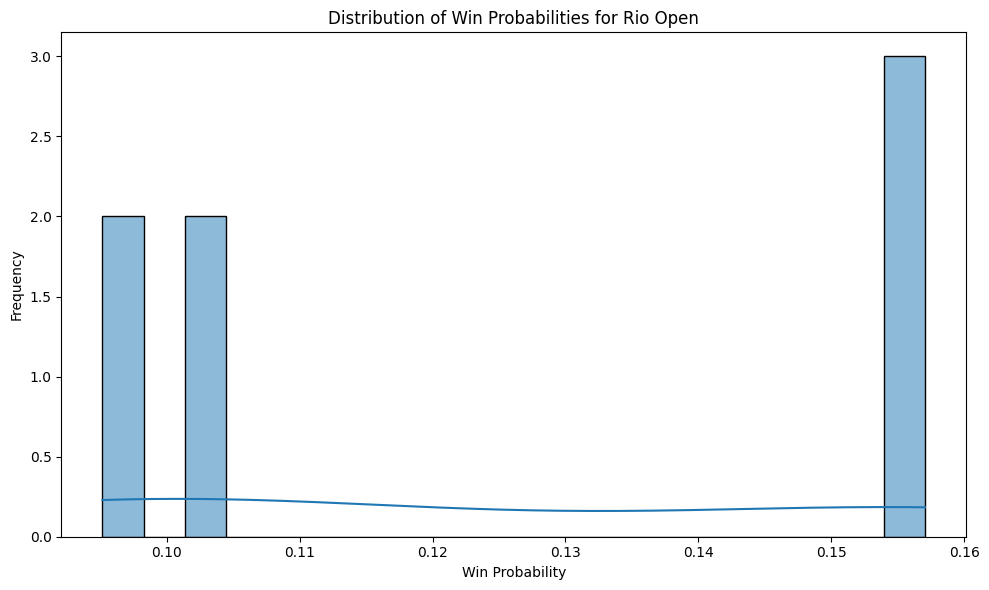

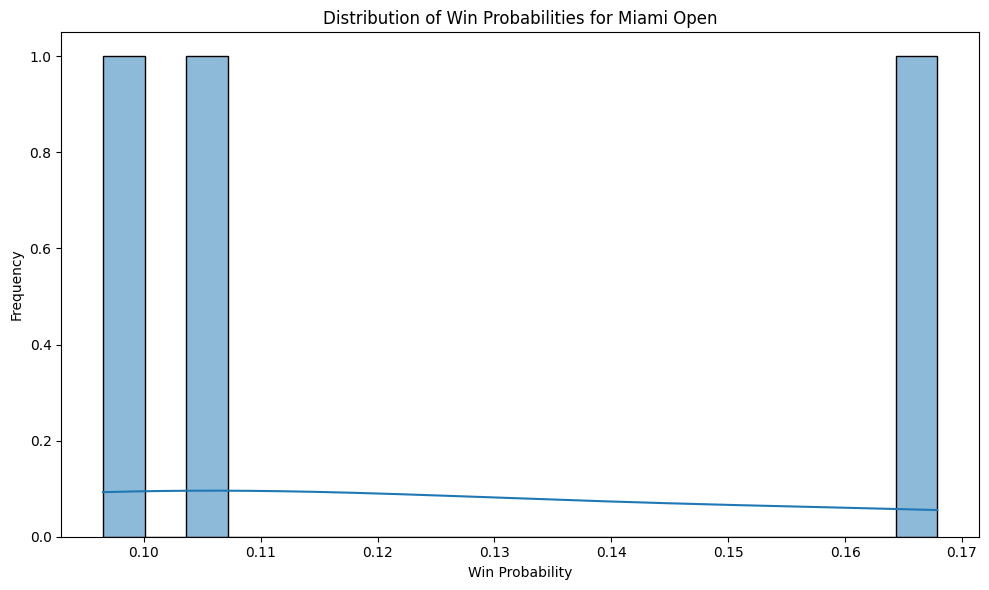

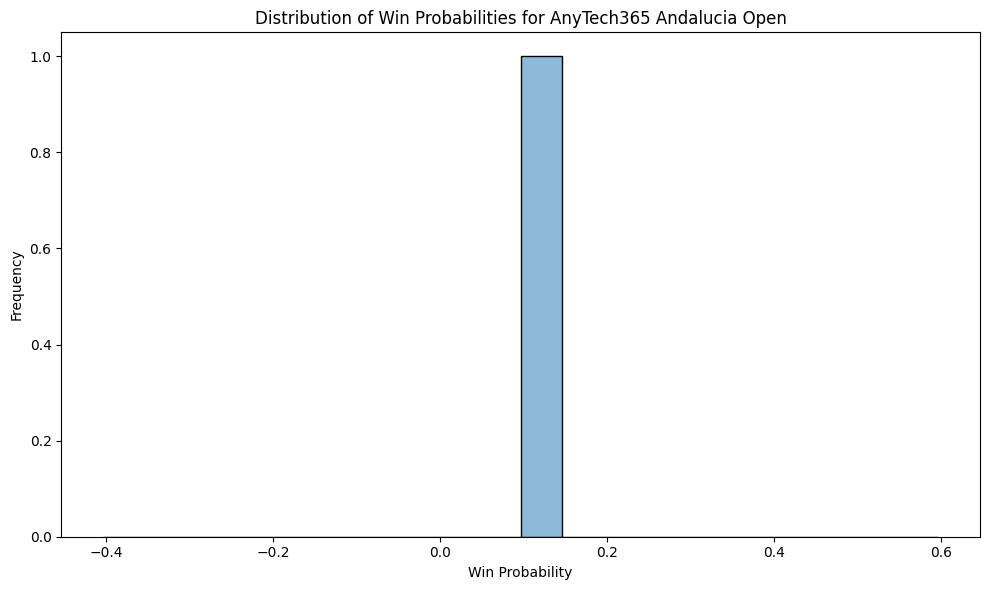

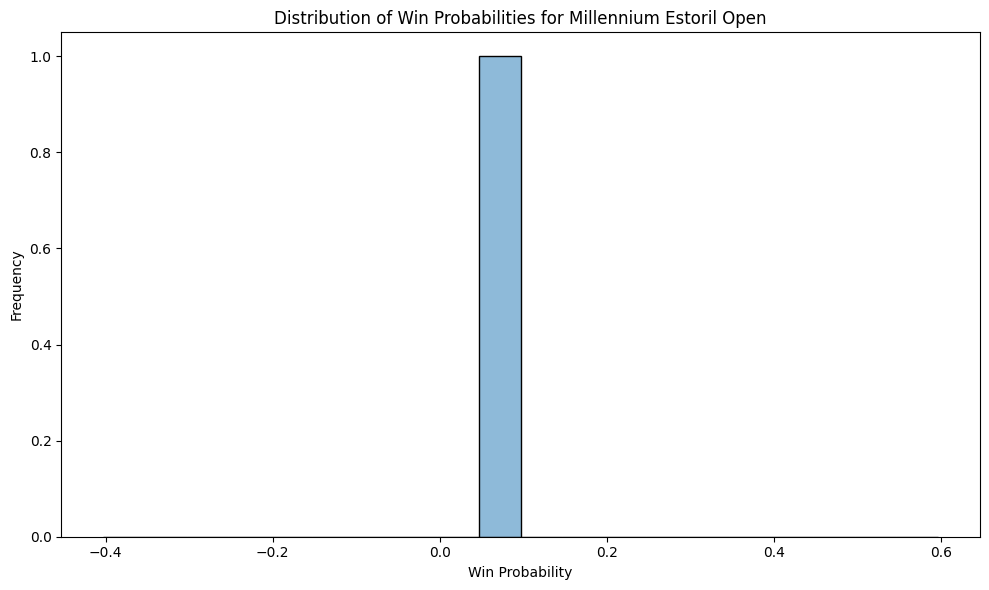

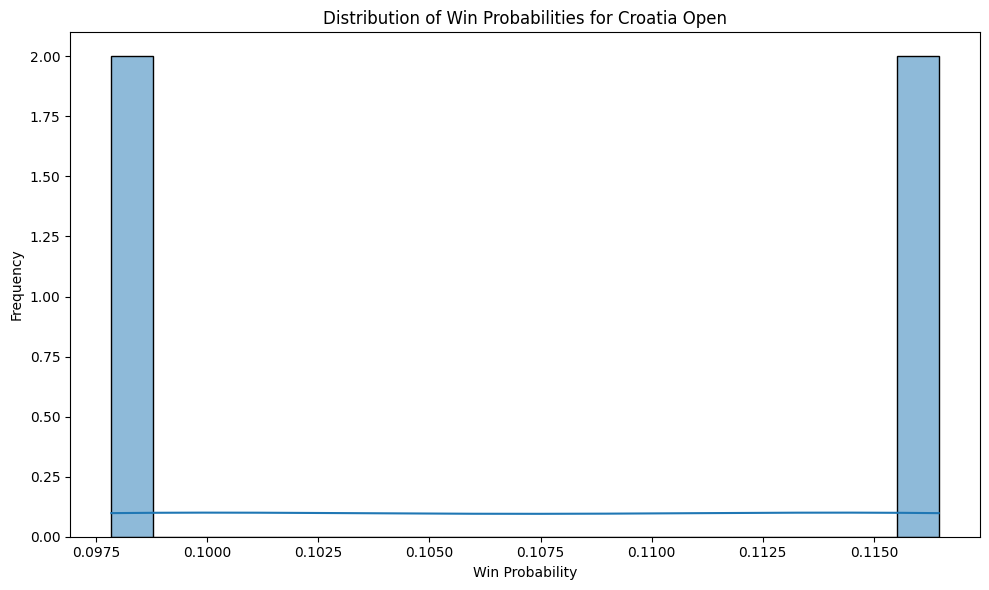

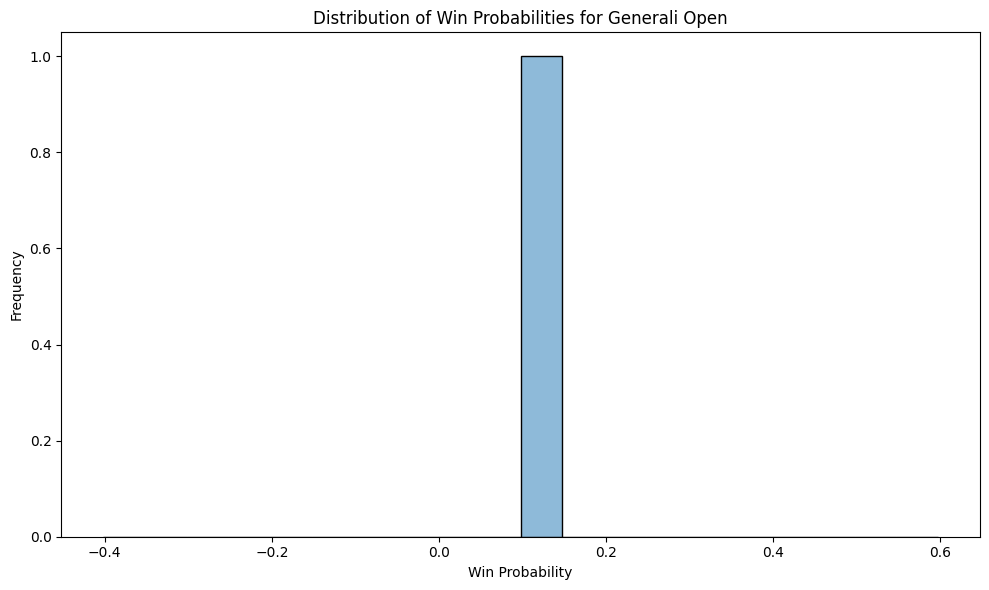

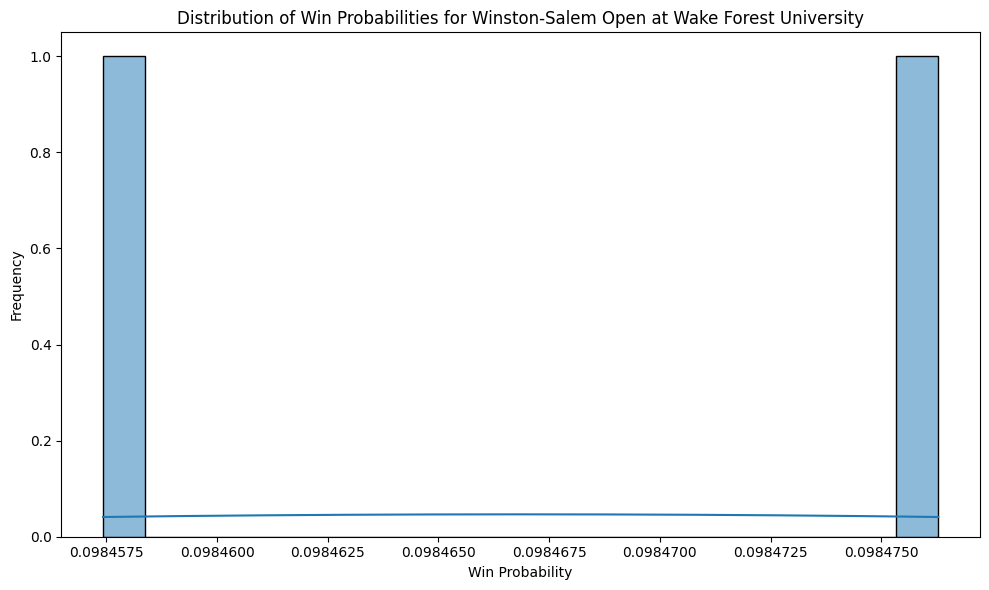

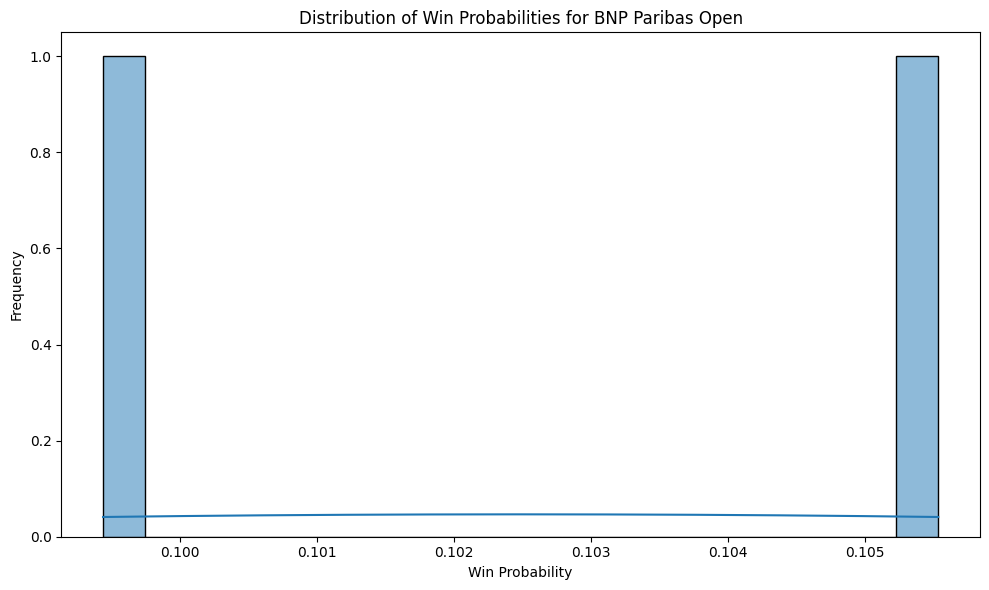

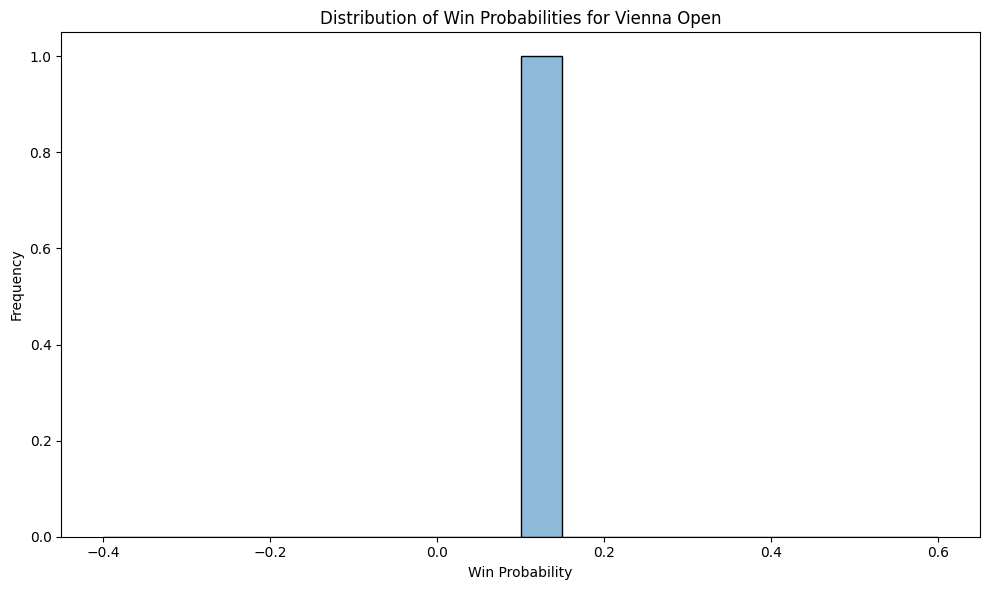

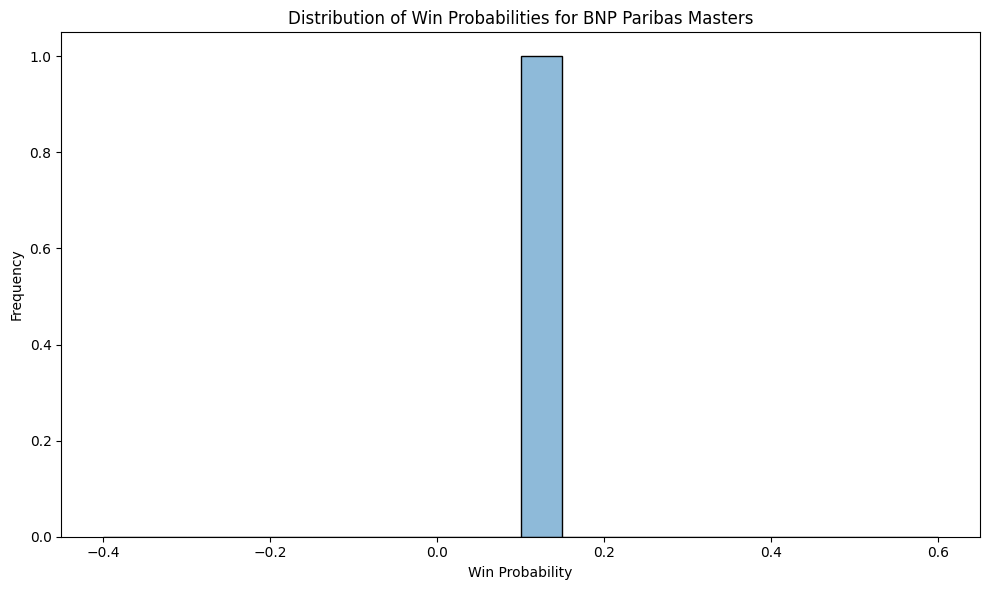

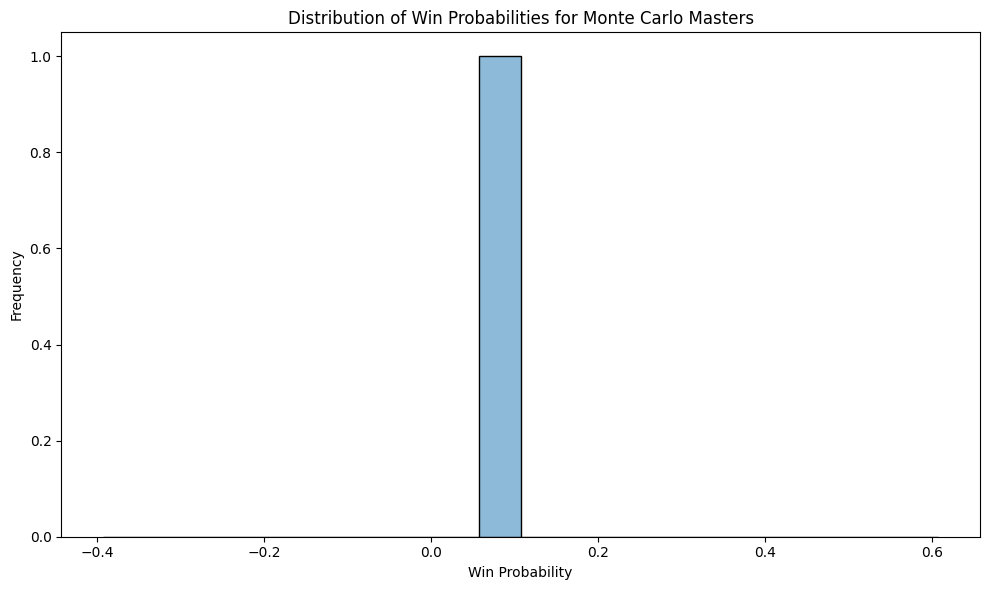

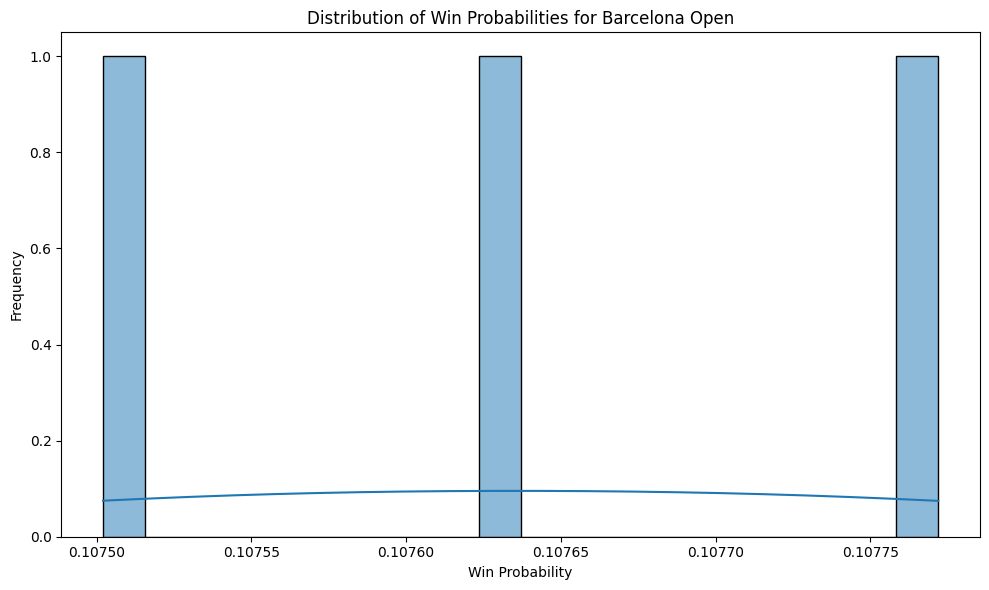

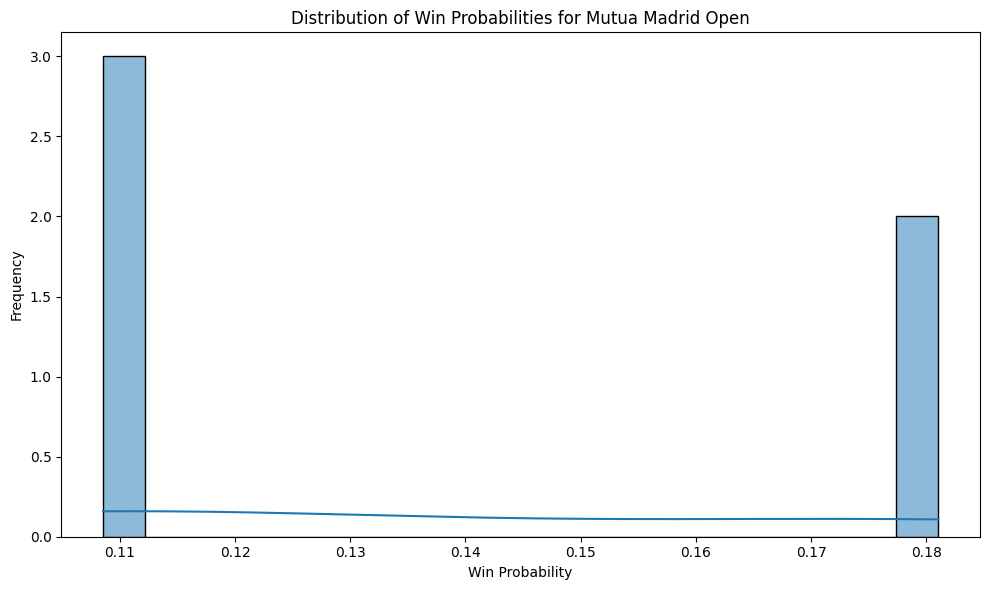

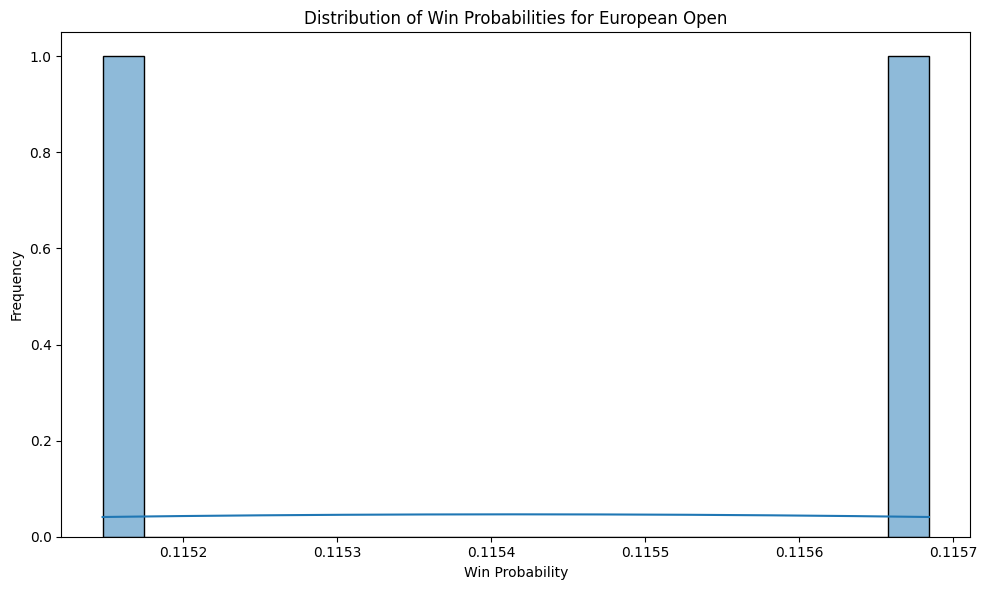

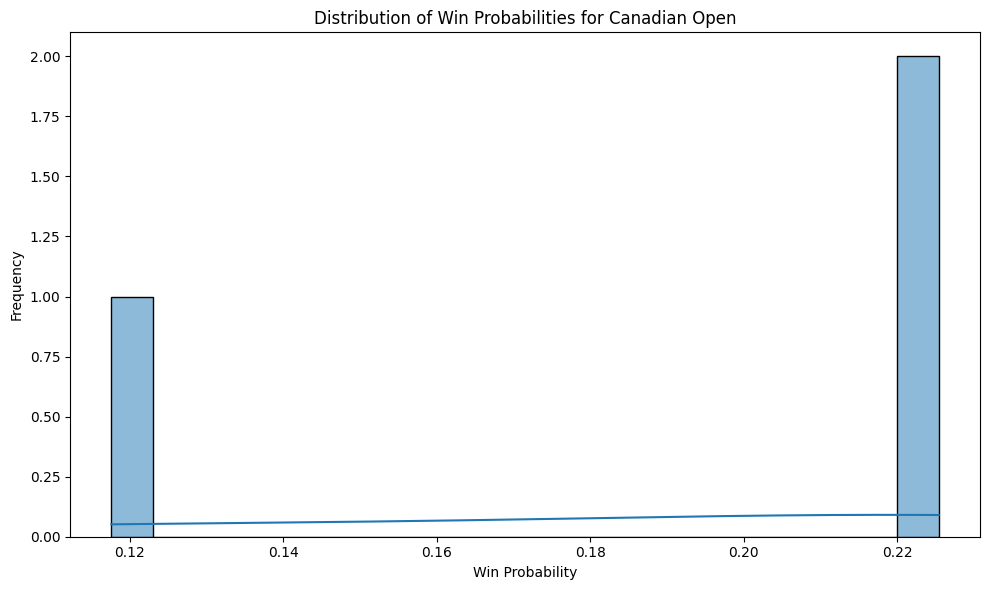

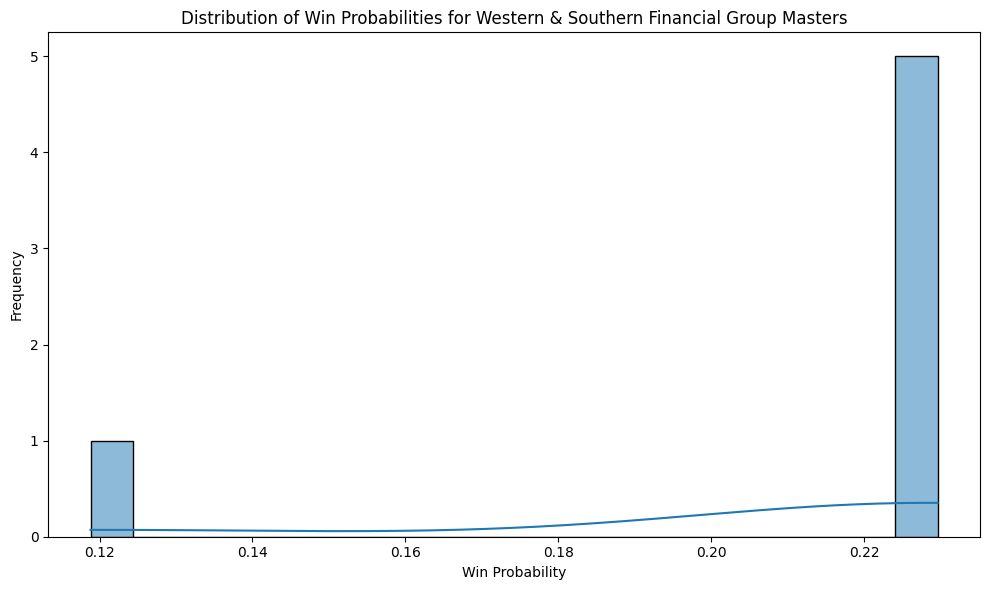

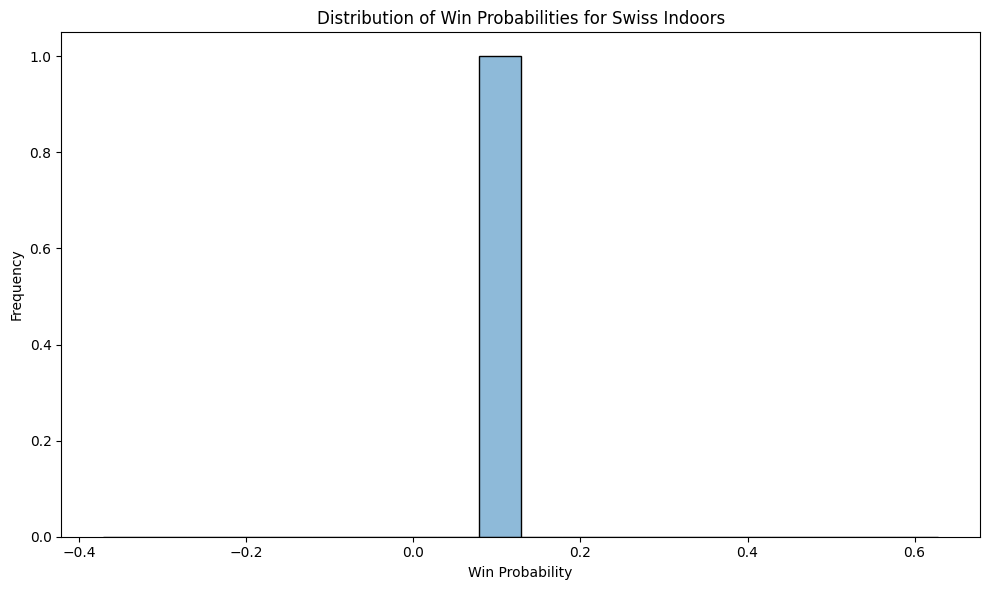

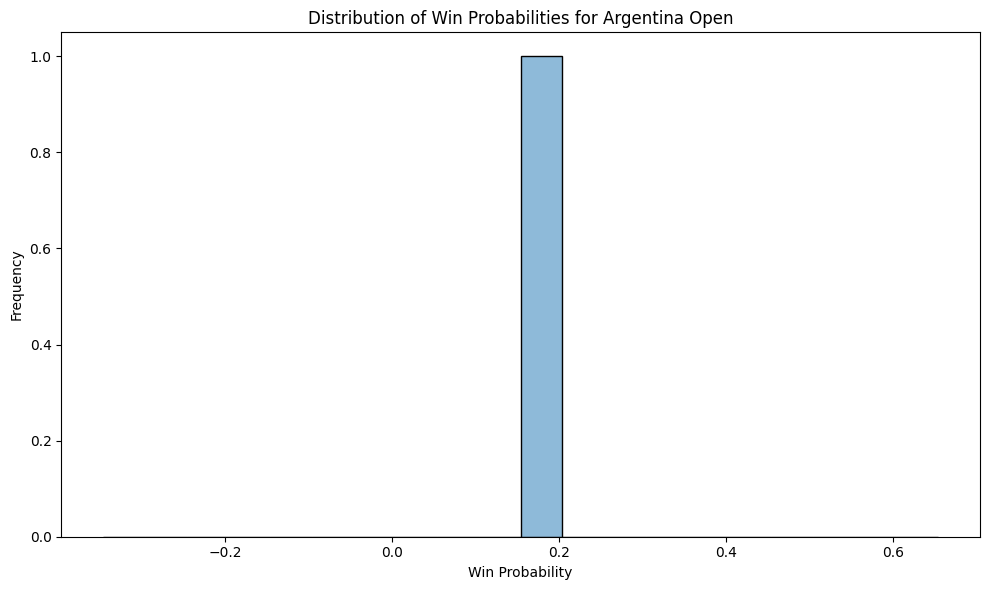

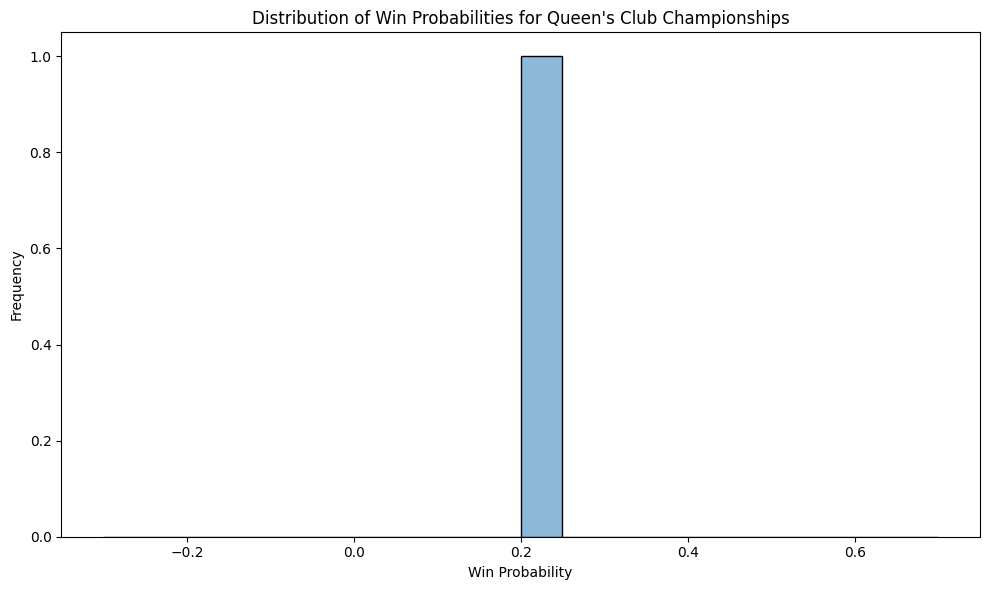

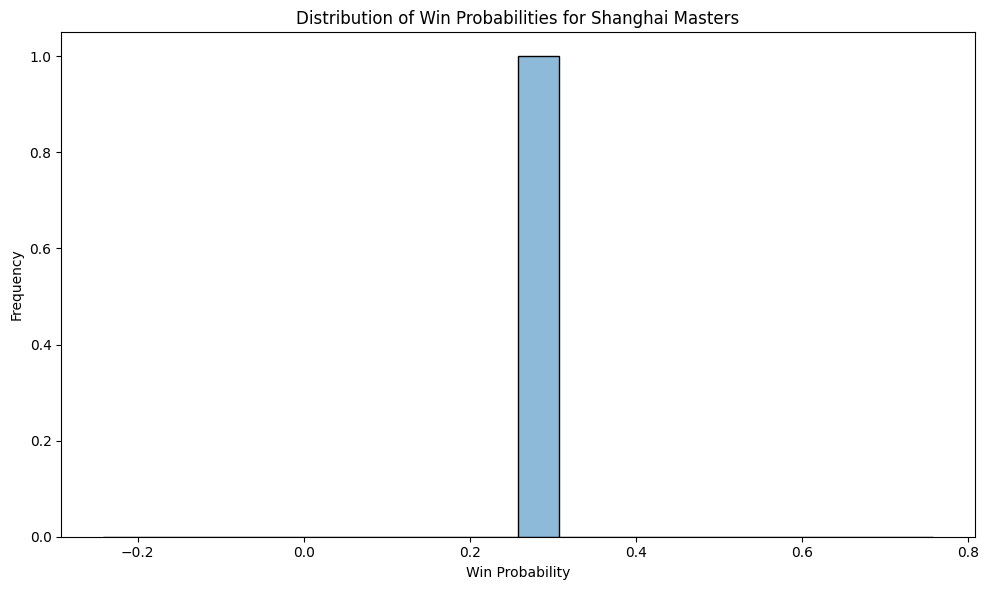

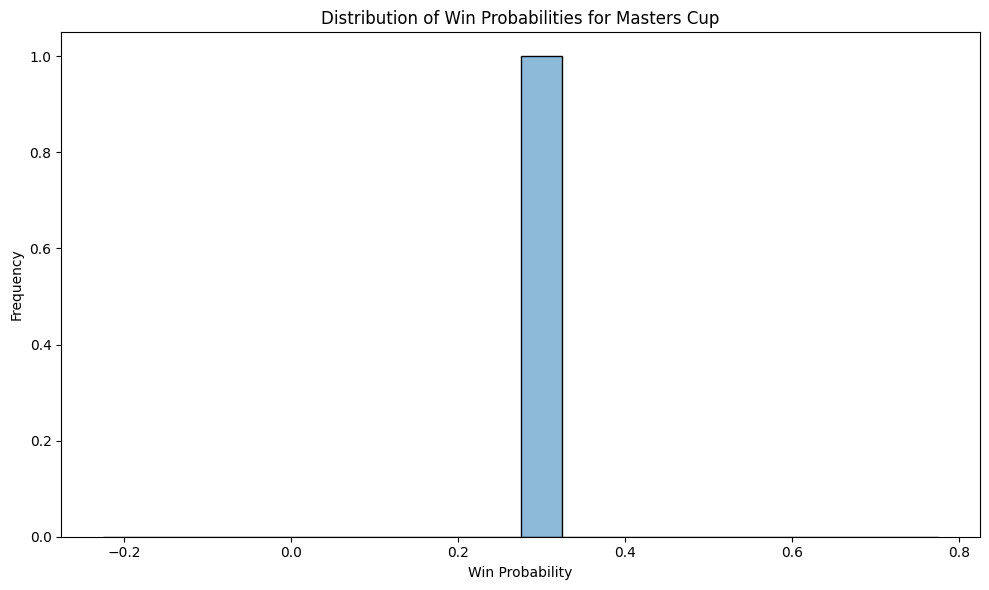

Images generated and saved in the 'img/' folder.


In [194]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Load the datasets
data = pd.read_csv('data/tennis_summaries_modified.csv')
new_matches_data = pd.read_csv('data/Alcaraz_C_matches_2020_2023_best_of_3.csv')

# Convert Winner ID to integer and add Outcome column
alcaraz_id = 407573
data['Winner ID'] = data['Winner ID'].astype('Int64')
data['Outcome'] = data['Winner ID']

# Filter out rows where Outcome is NaN (if any)
data = data.dropna(subset=['Outcome'])

# Ensure 'Start Date' is in datetime format
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
new_matches_data['Date'] = pd.to_datetime(new_matches_data['Date'], errors='coerce')
new_matches_data = new_matches_data.rename(columns={'Date': 'Start Date', 'Tournament': 'Competition Name'})

# Remove rows with invalid dates
data = data.dropna(subset=['Start Date'])
new_matches_data = new_matches_data.dropna(subset=['Start Date'])

# Convert 'Start Date' to numeric format for the model
data['Start Date'] = data['Start Date'].map(pd.Timestamp.toordinal)
new_matches_data['Start Date'] = new_matches_data['Start Date'].map(pd.Timestamp.toordinal)

# Extract relevant features and target from data
required_features = ['Competition Name', 'Start Date']
X = data[required_features]
y = data['Outcome']

# Check class distribution
class_counts = y.value_counts()
print(f"Class distribution before SMOTE: {class_counts}")

# Define a preprocessing pipeline for one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Start Date']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Competition Name'])
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
print(f"Shape of X_preprocessed: {X_preprocessed.shape}")

# Balance the dataset using SMOTE with adjusted k_neighbors
smote = SMOTE(k_neighbors=min(5, class_counts.min() - 1), random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)
print(f"Shape of X_resampled: {X_resampled.shape}")

# Check class distribution after SMOTE
class_counts_resampled = pd.Series(y_resampled).value_counts()
print(f"Class distribution after SMOTE: {class_counts_resampled}")

# Create a pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('classifier', VotingClassifier(estimators=[
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ], voting='soft'))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)

print(f"Voting Ensemble Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Prepare new match data for prediction
new_X = new_matches_data[required_features]
print(f"Shape of new_X before preprocessing: {new_X.shape}")

# Preprocess new match data using the same pipeline
new_X_scaled = preprocessor.transform(new_X)
print(f"Shape of new_X_scaled: {new_X_scaled.shape}")

# Predict probabilities for new matches
new_matches_data['Win Probability'] = pipeline.predict_proba(new_X_scaled)[:, 1]

# Convert 'Start Date' back to datetime for plotting and sort by date
new_matches_data['Start Date'] = new_matches_data['Start Date'].apply(pd.Timestamp.fromordinal)
new_matches_data = new_matches_data.sort_values(by='Start Date')

# Plot win probabilities without threshold
def plot_win_probabilities(matches_data, match_dates_column, win_prob_column, tournament_column):
    plt.figure(figsize=(14, 8))
    tournaments = matches_data[tournament_column].unique()
    for tournament in tournaments:
        tournament_data = matches_data[matches_data[tournament_column] == tournament]
        plt.bar(tournament_data[match_dates_column].dt.strftime('%Y-%m-%d'), tournament_data[win_prob_column], 
                label=tournament)
    
    plt.xticks(rotation=45)
    plt.xlabel('Match Date')
    plt.ylabel('Win Probability')
    plt.title('Predicted Win Probabilities for Upcoming Matches (2024)')
    plt.legend(title='Tournament', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('img/win_probabilities.png')
    plt.show()

# Plot the win probabilities as a combined bar graph
plot_win_probabilities(new_matches_data, match_dates_column='Start Date', win_prob_column='Win Probability', tournament_column='Competition Name')

# Feature importance analysis
# Convert the sparse matrix to dense format
X_train_dense = X_train.toarray()
column_names = ['Start Date'] + preprocessor.named_transformers_['cat'].get_feature_names_out(['Competition Name']).tolist()
X_train_relevant = pd.DataFrame(X_train_dense, columns=column_names)
print(f"X_train_relevant shape: {X_train_relevant.shape}")
print(f"First few rows of X_train_relevant:\n{X_train_relevant.head()}")

# Directly use X_train_dense for permutation importance without re-transforming
importances = permutation_importance(pipeline.named_steps['classifier'], X_train_dense, y_train, n_repeats=10, random_state=42)

plt.figure(figsize=(10, 6))
plt.barh(column_names, importances.importances_mean)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.tight_layout()
plt.savefig('img/feature_importance.png')
plt.show()

# Win probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(new_matches_data['Win Probability'], bins=20, kde=True)
plt.xlabel('Win Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Win Probabilities for Upcoming Matches')
plt.tight_layout()
plt.savefig('img/win_probability_distribution.png')
plt.show()

# Tournament-specific analysis
for tournament in new_matches_data['Competition Name'].unique():
    plt.figure(figsize=(10, 6))
    sns.histplot(new_matches_data[new_matches_data['Competition Name'] == tournament]['Win Probability'], bins=20, kde=True)
    plt.xlabel('Win Probability')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Win Probabilities for {tournament}')
    plt.tight_layout()
    plt.savefig(f'img/{tournament}_win_probability_distribution.png')
    plt.show()

print("Images generated and saved in the 'img/' folder.")
